In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import datetime

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib

# metrics
from sklearn.metrics import r2_score

# custom
from reflectance import plotting, file_ops, optimisation_pipeline, spectrum_utils, ml_utils

# TO DO
- ~~pipeline~~
- ~~full parameter sweep~~
- ~~other models? NN?~~
- ~~feature importance visualisation~~
- ~~Does CCA disappear on grouping?~~ – no, just shifts everything else up
- ~~Test NN – pytorch?~~
- ~~fitting for depth~~
- ~~get uncertainty from RF?~~
- ~~fix plotting shading~~
- ~~visualise by site/depth~~
- ~~better simulation~~
- ~~add synthetic as train data source~~
- visualise variance on feature: look into calculation of rolling importance
- apply ML to wider images
- statistical significance of depth on fit? ANOVA! (just to piss Eric off)
- emulate S2 from validation spectra


In [2]:
# load labels (recorded benthic cover)
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_data.head()

,X,Y,Campaign,Locale,Station,TimeUTC,TimeLocal,Depth,Metabolism,Optics,...,othInvert,othOther,othSponge,othUrchin,sedLimest,sedMud,sedRubble,sedSand,ROInumber,Flightline
0,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
1,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
2,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
3,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
4,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img


In [3]:
(X_train, X_test), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()
print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])

N train samples: 3100
N features: 84
N test samples: 388
Label dimensions: 3


In [4]:
labels

,algae,coral,sand
864,31,69.0,0
1674,77,19.0,3
1628,71,0.0,29
752,31,10.0,59
598,19,80.0,1
...,...,...,...
1130,41,1.0,58
1294,78,12.0,7
860,31,69.0,0
1459,80,20.0,0


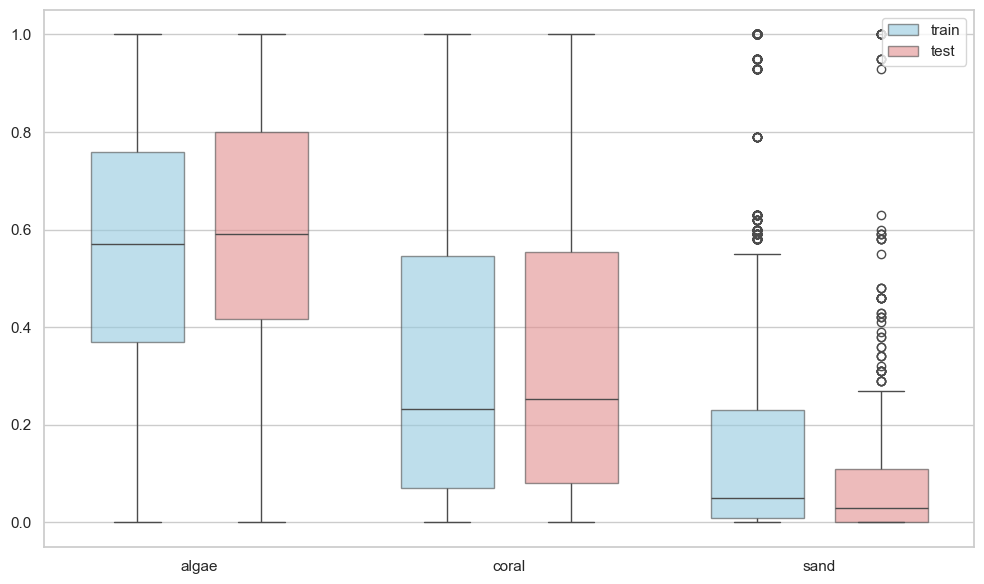

In [5]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=y_train, ax=ax, positions=np.arange(len(y_train.columns)) - 0.2, width=0.3, color="skyblue", boxprops=dict(alpha=0.6), label="train")
sns.boxplot(data=y_test, ax=ax, positions=np.arange(len(y_test.columns)) + 0.2, width=0.3, color="lightcoral", boxprops=dict(alpha=0.6), label="test")

plt.legend()
plt.tight_layout()

In [25]:
save_models = False
# best_rf = ml_utils.sklModels(model_type="random_forest", n_iter_search=100).return_fitted_model(X_train, y_train)
# best_gbr = ml_utils.sklModels(model_type="gradient_boosting", n_iter_search=1000).return_fitted_model(X_train, y_train)
best_mlp = ml_utils.sklModels(model_type="mlp", n_iter_search=500).return_fitted_model(X_train, y_train)

if save_models:
    # make directory
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    current_models_dir = file_ops.get_dir(file_ops.MODELS_DIR_FP / timestamp)

    joblib.dump(best_gbr, current_models_dir / "best_gbr.pkl")
    joblib.dump(best_rf, current_models_dir / "best_rf.pkl")
    joblib.dump(best_mlp, current_models_dir / "best_mlp.pkl")

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 384 is smaller than n_iter=500. Running 384 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization has

RandomizedSearchCV took 2391.95 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.844 (std: 0.021)
Parameters: {'tol': 0.0001, 'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'activation': 'relu'}
Model with rank: 2
Mean validation score: 0.840 (std: 0.022)
Parameters: {'tol': 1e-09, 'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'activation': 'relu'}
Model with rank: 3
Mean validation score: 0.835 (std: 0.046)
Parameters: {'tol': 0.0001, 'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'activation': 'relu'}


In [7]:
joblib.dump(best_gbr, current_models_dir / "best_gbr.pkl")
joblib.dump(best_rf, current_models_dir / "best_rf.pkl")
joblib.dump(best_mlp, current_models_dir / "best_mlp.pkl")



NameError: name 'timestamp' is not defined

In [22]:
# predict
fitted_rf = best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R^2 for RandomForest: {r2_rf:.3f}")

# y_pred_gbr = best_gbr.predict(X_test)
# r2_gbr = r2_score(y_test, y_pred_gbr)
# print(f"R^2 for MultiOutputGradientBoosted: {r2_gbr:.3f}")

y_pred_mlp = best_mlp.predict(X_test)
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"R^2 for MLP: {r2_mlp:.3f}")

R^2 for RandomForest: 0.793
R^2 for MLP: 0.852


In [23]:
def get_model_std_dev(model, y_test: pd.DataFrame) -> pd.DataFrame:

    predictions = []
    for i, tree in enumerate(fitted_rf.estimators_):
        predictions.append(tree.predict(X_test))
        
    np.array(predictions).shape
    stds = np.std(predictions, axis=0)
    
    return stds
            
def generate_model_metadata(validation_data, model, y_test):
    std_dev_predictions = get_model_std_dev(model, y_test)
    predictions_std_dev = pd.DataFrame(std_dev_predictions, index=y_test.index, columns=[col + "_std_dev" for col in y_test.columns])
    return pd.concat([validation_data.loc[y_test.index, ["Locale", "Depth"]], predictions_std_dev], axis=1)
    # metadata_multiindex = pd.MultiIndex.from_product([["metadata"], metadata.columns], names=["source", "label"])
    # return pd.DataFrame(metadata.values, index=y_test.index, columns=metadata_multiindex)
    

# Combine test_data with information from validation_data
test_data = y_test
# pred_data = pd.DataFrame(y_pred_rf, columns=labels.columns, index=y_test.index)
pred_data = y_pred_rf


metadata = generate_model_metadata(validation_data, fitted_rf, y_test)
# # get_std_dev(pred_data, test_data)
# predictions_std_dev = get_std_dev(pred_data[:,0], test_data.iloc[:,0])
# predictions_std_dev = 


# metadata_df = pd.DataFrame(metadata.values, index=y_test.index, columns=metadata_multiindex)

# metadata_df
# # # Convert predictions to a numpy array
# # predictions = np.array(predictions)
# # std_dev_predictions = pd.Series(np.std(predictions, axis=0), index=y_test.index, name="std_dev")

# # Fetch df indices of test_data to select metadata
# metadata = pd.concat([validation_data.loc[y_test.index, ["Locale", "Depth"]], std_dev_predictions], axis=1)


In [17]:
# # Combine test_data and pred_data in a multiindex dataframe
# data_multiindex = pd.MultiIndex.from_product([["true", "pred"], labels.columns], names=["source", "label"])
# combined_data = np.hstack([test_data, pred_data])
# data_df = pd.DataFrame(combined_data, index=y_test.index, columns=data_multiindex)

# # Concatenate data_df and metadata_df
# results_df = pd.concat([data_df, metadata_df], axis=1)
# results_df

In [12]:
test_data = y_test
pred_data = y_pred_mlp

# plotting.plot_regression_results(test_data, pred_data, labels, metadata=metadata, color_by="Depth")

In [61]:
labels.shape

(1938, 3)

ValueError: 'c' argument has 776 elements, which is inconsistent with 'x' and 'y' with size 2328.

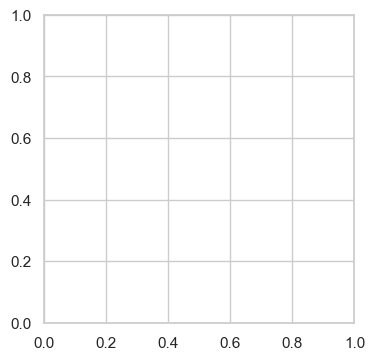

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plotting.plot_regression_axis(fig, axes, test_data, pred_data, labels, 
                              metadata=metadata,
                              color_by="Depth")

In [28]:
metadata

source       metadata                                               
label          Locale Depth algae_std_dev coral_std_dev sand_std_dev
1881            Palau   9.8      0.045539       0.02024     0.045067
1810            Palau  12.8      0.103356      0.121754     0.018607
351     Lizard Island   1.8       0.07457      0.064495     0.061648
562      Heron Island   4.0      0.088288      0.211777     0.110251
302     Lizard Island   1.6      0.047541      0.051338     0.083256
...               ...   ...           ...           ...          ...
1320      Kaneohe Bay   5.5      0.224326        0.2514     0.024646
1034             Maui   5.5      0.179602      0.162048      0.04175
513      Heron Island   4.6      0.118208      0.139007     0.019211
1710            Palau   7.6           0.0           0.0          0.0
691      Heron Island   1.5      0.078156      0.089209     0.056416

[776 rows x 5 columns]

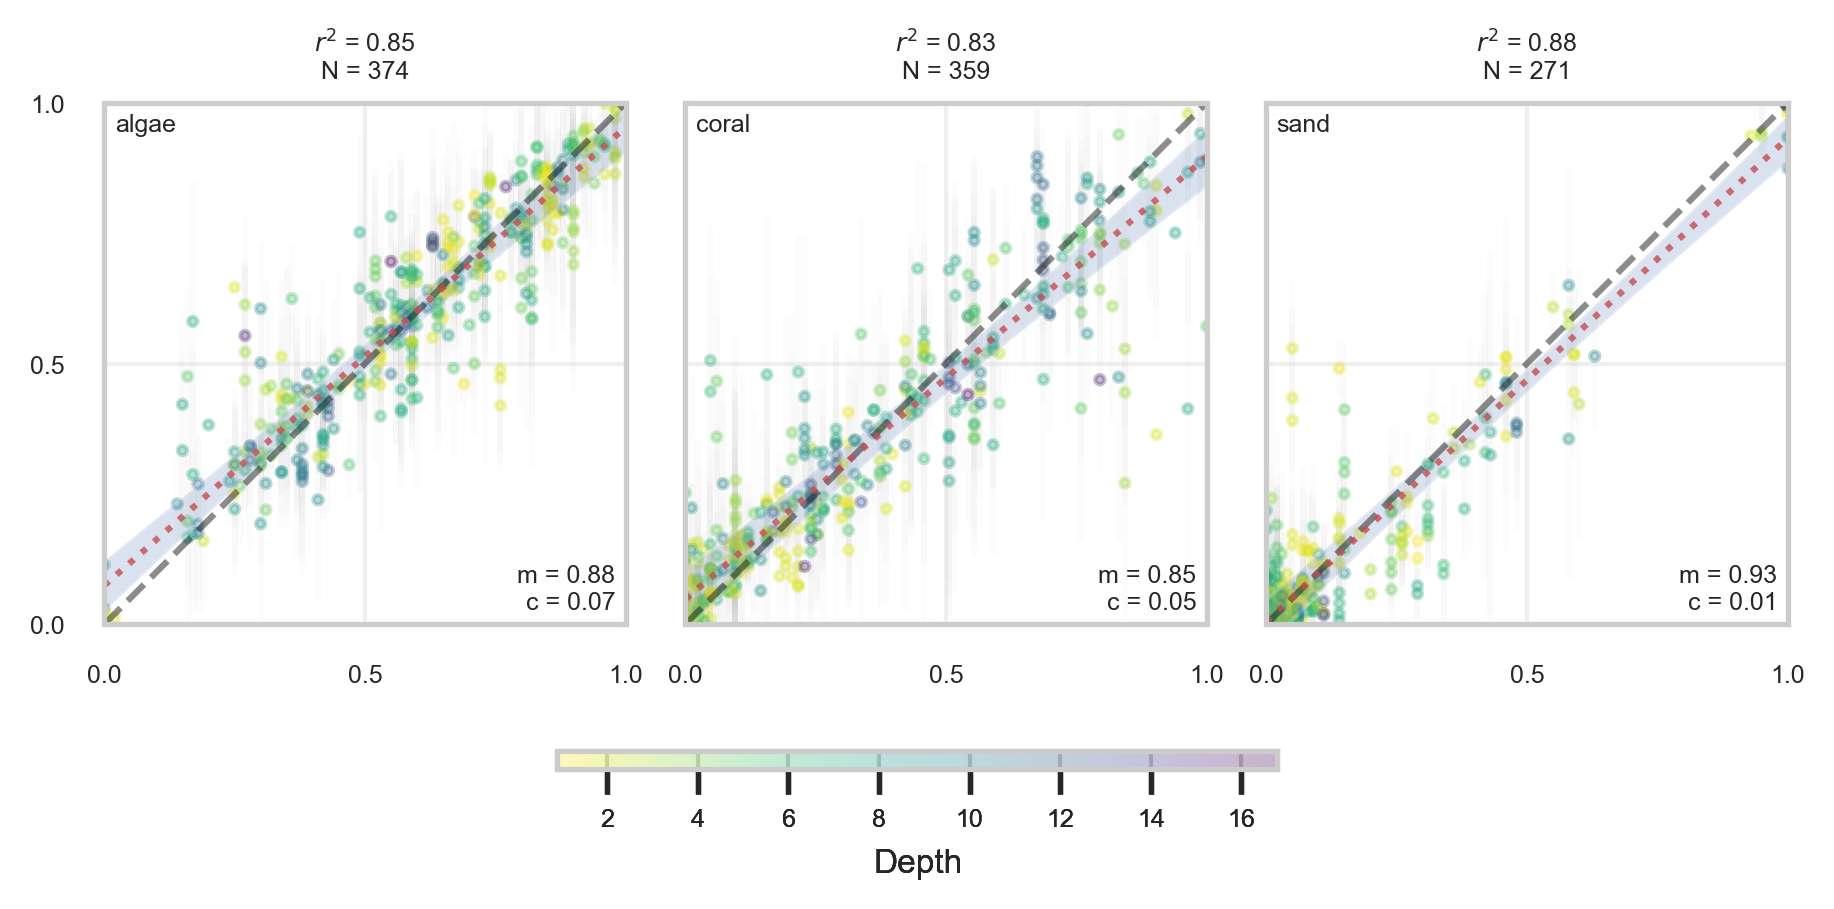

In [24]:
test_data = y_test
pred_data = y_pred_mlp

plotting.plot_regression_results(test_data, pred_data, labels,
                                 metadata=metadata,
                                 color_by="Depth")

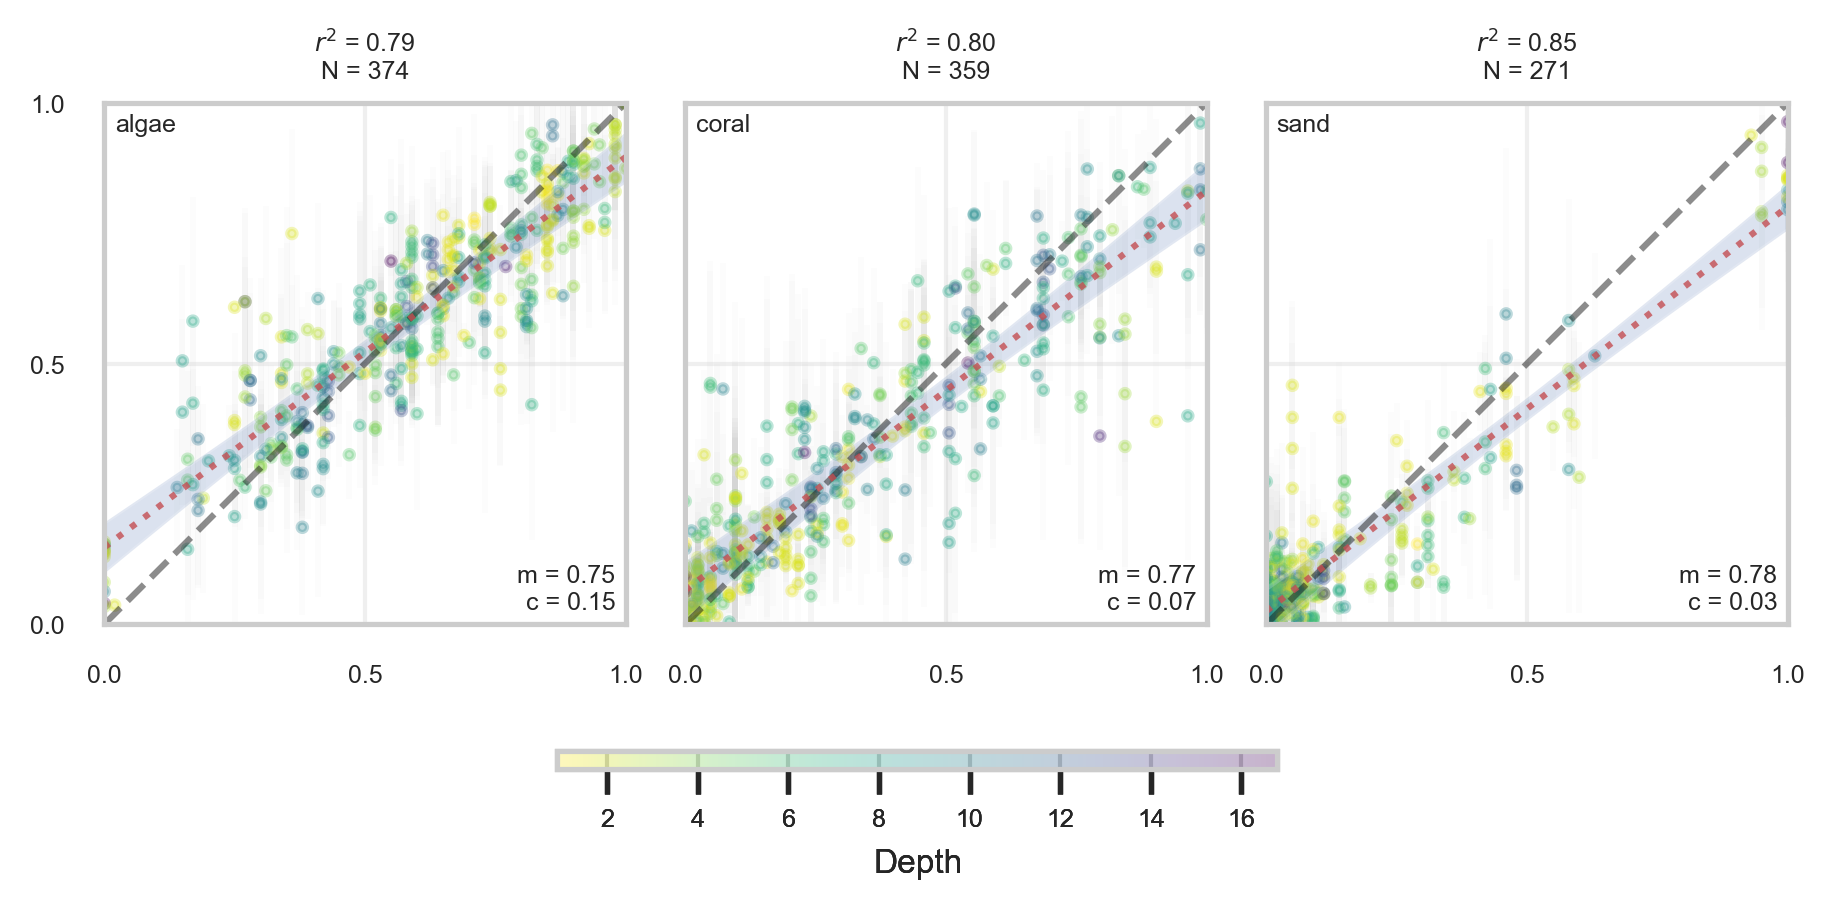

In [78]:
test_data = y_test
pred_data = y_pred_mlp

plotting.plot_regression_results(test_data, pred_data, labels,
                                 metadata=metadata, 
                                 color_by="Depth")

In [94]:
errors_df = test_data - pred_data
# errors_df["Depth"] = metadata["Depth"]


In [98]:
from scipy.stats import pearsonr, spearmanr

# for each label, run a statistical test to see dependence on depth
correlation_results = {}

# Loop through each target and compute the correlation with depth
for target in errors_df.columns:
    # Pearson correlation
    pearson_corr, pearson_p = pearsonr(metadata["Depth"], errors_df[target])
    
    # Spearman correlation (alternative to Pearson if you prefer a rank-based test)
    spearman_corr, spearman_p = spearmanr(metadata["Depth"], errors_df[target])
    
    # Store the results in a dictionary
    correlation_results[target] = {
        'Pearson Correlation': pearson_corr,
        'Pearson p-value': pearson_p,
        'Spearman Correlation': spearman_corr,
        'Spearman p-value': spearman_p
    }

# Convert the results dictionary into a DataFrame for easy viewing
correlation_df = pd.DataFrame(correlation_results).T
correlation_df


,Pearson Correlation,Pearson p-value,Spearman Correlation,Spearman p-value
algae,-0.127788,0.011757,-0.122643,0.015644
coral,0.049309,0.332679,0.105318,0.038117
sand,0.117922,0.020157,0.082346,0.105331
Depth,1.000000,0.000000,1.000000,0.000000


In [193]:
# test the statistical significance on depth on the accuracy of the model
import statsmodels.api as sm

# calculate error for each class
error = test_data - pred_data
error_df = pd.DataFrame(error, columns=labels.columns)
error_df["Depth"] = metadata["Depth"]
error_df = error_df.melt(id_vars="Depth", var_name="label", value_name="error")
error_df['intercept'] = 1

error_df

,Depth,label,error,intercept
0,11.3,algae,-0.268383,1
1,10.1,algae,-0.072241,1
2,7.6,algae,0.130832,1
3,6.1,algae,0.072937,1
4,5.8,algae,0.038203,1
...,...,...,...,...
1159,2.0,sand,-0.037806,1
1160,0.9,sand,0.162448,1
1161,5.5,sand,-0.071375,1
1162,7.9,sand,-0.021844,1


In [195]:
# Fit the regression model
model = sm.OLS(error_df['error'], error_df[['intercept', 'Depth']]).fit()
print(model.summary())

# ANOVA
from statsmodels.formula.api import ols
model = ols("error ~ Depth", data=error_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03058
Date:                Mon, 30 Sep 2024   Prob (F-statistic):              0.861
Time:                        15:18:04   Log-Likelihood:                 636.75
No. Observations:                1164   AIC:                            -1270.
Df Residuals:                    1162   BIC:                            -1259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.008     -0.274      0.7

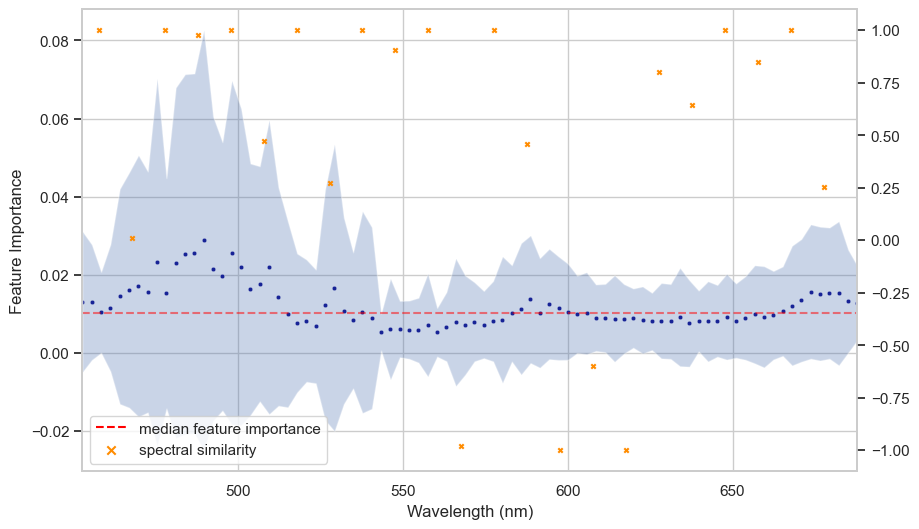

In [526]:
# plot a scatterplot of mean importance, with std shaded
rf_importances = np.array([tree.feature_importances_ for tree in best_rf.estimators_])
importance_df = pd.DataFrame(rf_importances, columns=X_train.columns).agg(["mean", "std"]).T

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=importance_df.index, y=importance_df["mean"], s=10, ax=ax, color="darkblue")
ax.fill_between(importance_df.index, importance_df["mean"] - importance_df["std"], importance_df["mean"] + importance_df["std"], alpha=0.3)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Feature Importance")
ax.set_xlim(min(importance_df.index), max(importance_df.index))
ax.hlines(np.median(importance_df["mean"]), min(importance_df.index), max(importance_df.index), linestyle="--", alpha=0.5, color="red")

kernel_width = 10
kernel_displacement = 10
ax_metric = ax.twinx()
wv_pairs, (mean_corrs, std_corrs) = spectrum_utils.calc_rolling_similarity(X_train.columns, X_test.values[:2,:], kernel_width, kernel_displacement, spectrum_utils.calc_spectral_similarity_gradient)
ax_metric.scatter([np.mean(pair) for pair in wv_pairs], mean_corrs, s=10, c="darkorange", marker="x", zorder=-100)
ax_metric.grid(False)

ax_metric.plot([],[],linestyle="--", color="red", label="median feature importance")
ax_metric.scatter([],[], color="darkorange", label="spectral similarity", marker="x")

ax_metric.legend()